In [1]:
# %matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import h5py
import scipy

from phantom_functions import create_ptycho_phantom, calculate_wavelength, read_probe_positions_new, convert_positions_to_pixels,set_object_size_pxls, load_data, get_simulated_data, read_probe_positions_in_pxls, set_object_frame
from ptycho_functions import get_circular_mask, get_positions_array, apply_invalid_regions, apply_random_shifts_to_positions

import sscCdi

/ibira/lnls/labs/tepui/apps/modules/python/3.9.2/lib/python3.9/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.0.0. is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
z1 = np.load('/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/mogno/RHD_Salditt/z_positions.npy')
z1 = z1[-1]*1e-3
z2 = 1 - z1

M = (z2+z1)/z1

z1, z2, M

(0.004278062, 0.995721938, 233.75070300523927)

In [26]:
c_speed = 299792458        # Velocity of Light [m/s]
planck  = 4.135667662E-18  # Plank constant [keV*s]

inputs = {
"path" : "",
"matrix_size": 20, # n of pixels; one side of cube
"n_cpus": 32, # cpu cores
"energy": 22, #keV
"detector_distance": z2, # meter
"distance": z2, # meter
"detector_pixel_size": 1.44e-6,
"probe_steps_xy": [5,5], # pixels
"n_of_angles": 0,
"source_distance": z1, # should be 0 if parallel beam
}

n_pixels = 1536
wavelength = c_speed * planck / inputs["energy"]
inputs["wavelength"] = wavelength
dx = wavelength*inputs["distance"]/(n_pixels*inputs["detector_pixel_size"])
inputs['object_pixel'] = inputs["detector_pixel_size"]

def get_positions_array(probe_steps_xy,frame_shape,random_positions=True):

    dx, dy = probe_steps_xy # probe step size in each direction
    y_pxls = np.array([5,10,15,20,25])
    x_pxls = y_pxls

    if random_positions == True:
        x_pxls,y_pxls = apply_random_shifts_to_positions(x_pxls,y_pxls,sigma = 10)

    positionsY,positionsX = np.meshgrid(y_pxls,x_pxls)
    
    if 0: # Plot positions map
        figure, ax = plt.subplots(dpi=100)
        ax.plot(positionsX,positionsY,'x',label='Original')
        ax.set_title('Positions') 
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_aspect('equal')
    
    return positionsX.flatten(),positionsY.flatten()

def set_object_frame(y_pxls, x_pxls,frame,probe,object_offset,path,save=True):
    obj = np.zeros(set_object_size_pxls(x_pxls,y_pxls,probe.shape,object_offset),dtype=complex)
    obj[object_offset:object_offset+frame.shape[0],object_offset:object_offset+frame.shape[1]] = frame
    return obj

def get_simulated_data(inputs, probe_steps_xy,random_positions=True,use_bad_points=False, add_position_errors=False,object_offset = 5):

    """ Create object """
    phase = np.array( np.load('/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/simulation_data/gravel256.npy')) # Load Imagem
    magnitude = np.array( np.load('/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/simulation_data/camera256.npy')) # Load Imagem

    A = 60
    magnitude[0:A,:] = magnitude[-A::,:] = 0
    magnitude[:,0:A] = magnitude[:,-A::] = 0
    phase[0:A,:] = phase[-A::,:] = 0
    phase[:,0:A] = phase[:,-A::] = 0    
    
    """ Create Probe """
    probe = np.random.rand(*magnitude.shape)
    probe = scipy.ndimage.gaussian_filter(probe,2)
    probe = probe/np.max(probe)
    probe = probe * np.exp(1j*np.pi*probe)
    
    positionsX,positionsY = get_positions_array(probe_steps_xy,probe.shape,random_positions)
    model_object = np.abs(magnitude/np.max(magnitude))*np.exp(1j*np.pi*phase/np.max(phase))
    
    fig, ax = plt.subplots(1,4,dpi=200)
    ax[0].imshow(magnitude), ax[0].set_title('Magnitude')
    ax[1].imshow(phase), ax[1].set_title('Phase')
    ax[2].imshow(np.abs(probe)), ax[2].set_title('Probe')

    model_object = set_object_frame(positionsY, positionsX,model_object,probe,object_offset,'',save=False)

    difpad = sscCdi.propagation.fresnel_propagator_cone_beam(model_object,inputs["wavelength"],inputs["detector_pixel_size"],inputs["distance"],inputs["source_distance"])
    ax[3].imshow(np.abs(difpad)), ax[3].set_title('Measurement')

    
    print('Model object:',model_object.shape)
    print('Probe: ',probe.shape)
    
    difpads = []
    for px,py in zip(positionsX,positionsY):
    
        """ Exit wave-field """
        W = model_object[py:py+probe.shape[0],px:px+probe.shape[1]]*probe
    
        """ Propagation """
        difpad = sscCdi.propagation.fresnel_propagator_cone_beam(W,inputs["wavelength"],inputs["detector_pixel_size"],inputs["distance"],inputs["source_distance"])
        # difpad = np.fft.fft2(W)
        # difpad = np.fft.fftshift(difpad)
        
        
        """ Measurement """
        difpad = np.absolute(difpad)**2
    
        if use_bad_points:# add invalid grid to data
            difpad = apply_invalid_regions(difpad)
        
        difpads.append(difpad)

    positions = np.hstack((np.array([positionsX]).T ,np.array([positionsY]).T)) # adjust positions format for proper input
    difpads = np.asarray(difpads)
    
    if add_position_errors:
        max_error = 0.1*np.mean(positions)
        positions_errors = max_error*np.random.rand(*positions.shape)
        positions += positions_errors
        return difpads, positions, model_object, probe, positions_errors
    else:
        positions_errors = []
        return difpads, positions, model_object, probe, positions_errors

# difpads, positions, model_object, probe, positions_errors = get_simulated_data(inputs, inputs["probe_steps_xy"])
# print(model_object.shape,probe.shape)
difpads = np.load('/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/mogno/RHD_Salditt/data.npy')
difpads.shape

(1640, 2048, 2048)

In [27]:
# N = 200 # crop DP 
A = 0 # crop positions

# DPs = difpads[A::,N:-N,N:-N]
DPs = difpads[A::]

# Get the size of the array in bytes
size_in_bytes = DPs.nbytes

# Convert the size to gigabytes
size_in_gb = size_in_bytes / (1024**3)

print("Size of the array:", size_in_gb, "GB")

Size of the array: 12.8125 GB


Object pixel = 1.44e-06 m
Probe shape = (2048, 2048)
Deleting 1340 slices
Object shape = (5063, 5320)
Data shape = (300, 2048, 2048)
Positions shape = (300, 2)
Size of the array: 12.8125 GB


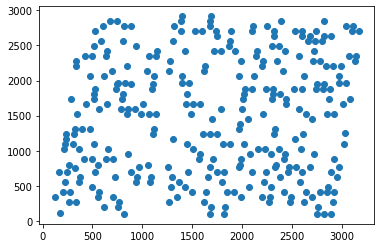

In [28]:
def convert_probe_positions_meters_to_pixels(offset_topleft, pixel_size, probe_positions):
    """
    Subtratcs minimum of position in each direction, converts from microns to pixels and then apply desired offset 
    """

    probe_positions[:, 0] -= np.min(probe_positions[:, 0]) # Subtract the probe positions minimum to start at 0
    probe_positions[:, 1] -= np.min(probe_positions[:, 1])

    probe_positions[:, 0] =  probe_positions[:, 0] / pixel_size  
    probe_positions[:, 1] =  probe_positions[:, 1] / pixel_size 
    
    probe_positions[:, 0] += offset_topleft # shift probe positions to account for the padding
    probe_positions[:, 1] += offset_topleft 

    return probe_positions


print(f'Object pixel = {inputs["object_pixel"]} m')

positions = np.load('/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/mogno/RHD_Salditt/positions.npy')[A::]

empty = np.load('/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/mogno/RHD_Salditt/empty.npy')#[N:-N,N:-N]
probe = np.ones_like(empty)

print(f'Probe shape = {probe.shape}')

inputs["object_padding"] = 100
positions = convert_probe_positions_meters_to_pixels(inputs["object_padding"],inputs["object_pixel"], positions.copy())


if 1:
    n_of_points_to_keep = 300
    start_idx = positions.shape[0] - n_of_points_to_keep
    slices_to_ignore = np.random.permutation(positions.shape[0])[-start_idx::]
    print(f'Deleting {slices_to_ignore.shape[0]} slices')
    DPs = np.delete(DPs,slices_to_ignore,axis=0)
    positions = np.delete(positions,slices_to_ignore,axis=0)


fig, ax = plt.subplots()
ax.plot(positions[:,1],positions[:,0],'o')

inputs = sscCdi.set_object_shape(inputs, DPs.shape, positions)
# inputs["object_shape"] = (inputs["object_shape"][1],inputs["object_shape"][0])
print(f'Object shape = {inputs["object_shape"]}')

print(f'Data shape = {DPs.shape}')
print(f'Positions shape = {positions.shape}')

print("Size of the array:", size_in_gb, "GB")

In [29]:
model_object = np.ones(inputs["object_shape"])

probe_guess = np.ones_like(probe) + 1j
probe_guess = probe + 1j
obj_guess = np.ones_like(model_object) # constant object

iterations = 10
n_of_modes = 1

inputs['iterations'] = iterations    
inputs["n_of_modes"] = n_of_modes

inputs['beta'] = 0.9 # RAAR
inputs['epsilon'] = 0.01 # RAAR; small value to add to probe/object update denominator

In [30]:
# # sscCdi.deploy_visualizer(difpads)
# import cupy as cp
# wavefronts = cp.ones((len(positions),n_of_modes,probe.shape[0],probe.shape[1]),dtype=complex)
# del wavefronts

In [31]:
positions = np.roll(positions,shift=1,axis=1)

positions.shape, DPs.shape, probe_guess.shape, obj_guess.shape

((300, 2), (300, 2048, 2048), (2048, 2048), (5063, 5320))

In [32]:
inputs["fresnel_regime"] = True
inputs["probe_support"] = None
inputs["incoherent_modes"] = 1
inputs

{'path': '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/ptycho3d/complex_phantom/',
 'matrix_size': 20,
 'n_cpus': 32,
 'energy': 22,
 'detector_distance': 0.995721938,
 'distance': 0.995721938,
 'detector_pixel_size': 1.44e-06,
 'probe_steps_xy': [5, 5],
 'n_of_angles': 0,
 'source_distance': 0.004278062,
 'wavelength': 5.6356453357367875e-11,
 'object_pixel': 1.44e-06,
 'object_padding': 100,
 'object_shape': (5063, 5320),
 'iterations': 10,
 'n_of_modes': 1,
 'beta': 0.9,
 'epsilon': 0.01,
 'fresnel_regime': True,
 'probe_support': None,
 'incoherent_modes': 1}

In [54]:
RAAR_obj, RAAR_probes, RAAR_error = sscCdi.ptychography.RAAR_multiprobe_cupy(DPs,positions,obj_guess,probe_guess,inputs)

propagated_probe = sscCdi.fresnel_propagator_cone_beam(RAAR_probes[0],inputs["wavelength"],inputs["detector_pixel_size"],z2,z1) 
propagated_probe /= np.max(propagated_probe)

RAAR_obj.shape, RAAR_probes.shape

	Iteration 0/10 	Error: 1.21e+02


((5063, 5320), (1, 2048, 2048))

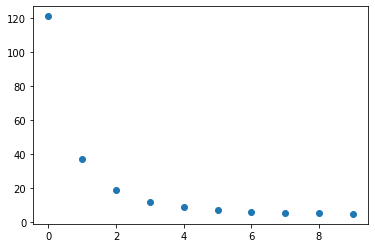

In [55]:
plt.figure()
plt.plot(RAAR_error, 'o')

In [56]:
# fig, ax = plt.subplots(1,4,figsize=(10,5),dpi=200)
# ax[0].imshow(np.abs(obj_guess)), ax[0].set_title('Initial Obj Mag')
# ax[1].imshow(np.angle(obj_guess)), ax[1].set_title('Initial Obj Phase')
# ax[2].imshow(np.abs(probe_guess)), ax[2].set_title('Initial Probe Mag')
# ax[3].imshow(np.angle(probe_guess)), ax[3].set_title('Initial Probe Phase')

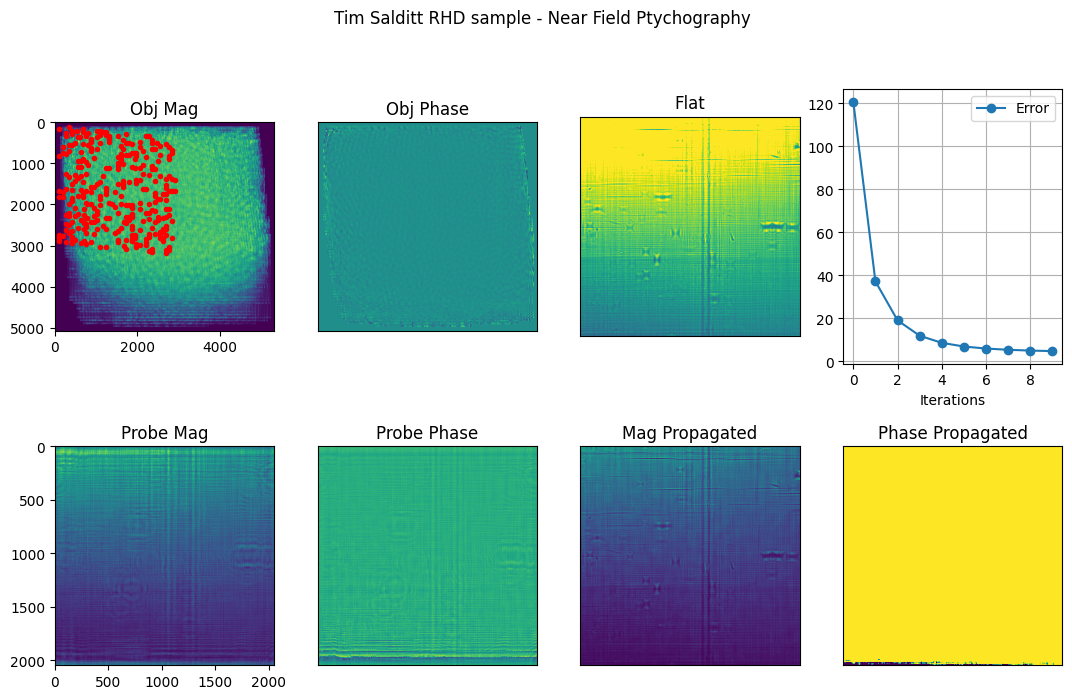

In [57]:
fig, ax = plt.subplots(2,4,figsize=(13,8),dpi=100)
ax[0,0].imshow(np.abs(RAAR_obj)), ax[0,0].set_title('Obj Mag')
ax[0,0].plot(positions[:,1],positions[:,0],'.',color='r')
ax[0,1].imshow(np.angle(RAAR_obj)), ax[0,1].set_title('Obj Phase')
ax[0,2].imshow(np.abs(empty),vmax=6000), ax[0,2].set_title('Flat')
ax[1,0].imshow(np.abs(RAAR_probes[0])), ax[1,0].set_title('Probe Mag')
ax[1,1].imshow(np.angle(RAAR_probes[0])), ax[1,1].set_title('Probe Phase')
ax[1,2].imshow(np.abs(propagated_probe),vmax=0.5), ax[1,2].set_title('Mag Propagated')
ax[1,3].imshow(np.angle(propagated_probe),vmax=0.1,vmin=-0.1), ax[1,3].set_title('Phase Propagated')
ax[0,3].plot(RAAR_error,'o-',label='Error')
ax[0,3].set_xlabel('Iterations')
ax[0,3].legend(), ax[0,3].grid()

fig.suptitle('Tim Salditt RHD sample - Near Field Ptychography')

for i, ax in enumerate(ax.ravel()):
    if i==3 or i==0 or i ==4: continue
    ax.set_xticks([])
    ax.set_yticks([])

In [64]:
inputs["regularization_object"] = 0.25
inputs["regularization_probe"] = 0.5
inputs["step_object"] = 0.7
inputs["step_probe"] = 0.5

inputs["friction_object"] = 0.9
inputs["friction_probe"] = 0.99
inputs["momentum_counter"] = 10
inputs["use_mPIE"] = False
PIE_obj, PIE_probes, PIE_error = sscCdi.PIE_multiprobe_loop(DPs, positions,obj_guess,probe_guess,inputs)

propagated_probe_PIE = sscCdi.fresnel_propagator_cone_beam(PIE_probes[0],inputs["wavelength"],inputs["detector_pixel_size"],z2,z1) 
propagated_probe_PIE /= np.max(propagated_probe_PIE)

	Iteration 0/10 	Error: 1.18e+01


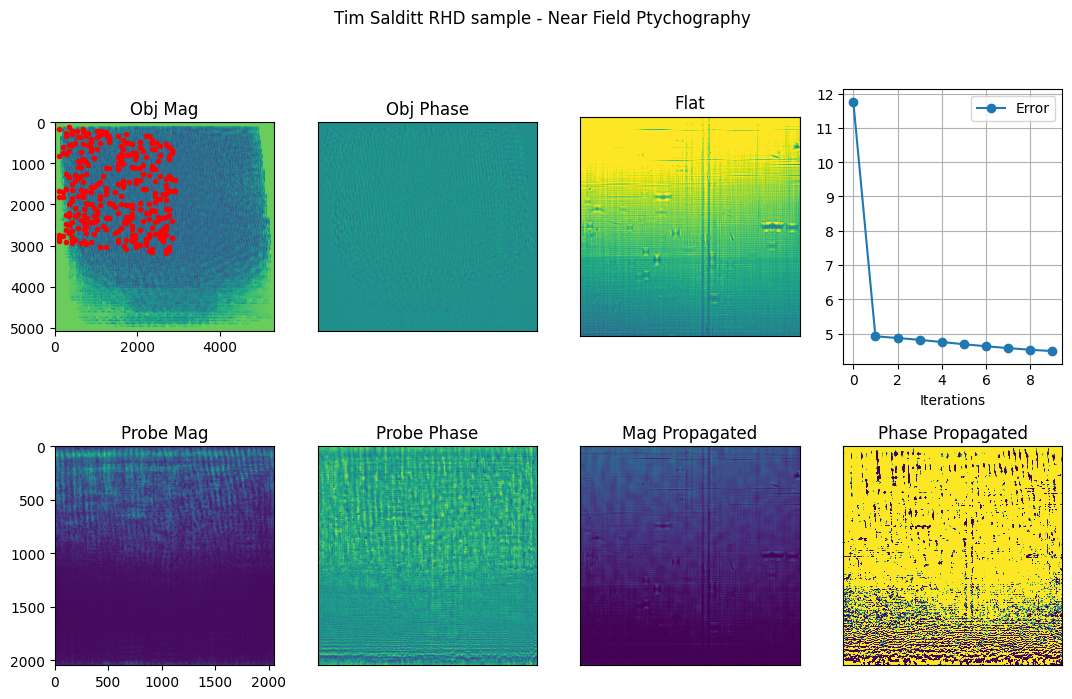

In [65]:
fig, ax = plt.subplots(2,4,figsize=(13,8),dpi=100)
ax[0,0].imshow(np.abs(PIE_obj[0])), ax[0,0].set_title('Obj Mag')
ax[0,0].plot(positions[:,1],positions[:,0],'.',color='r')
ax[0,1].imshow(np.angle(PIE_obj[0])), ax[0,1].set_title('Obj Phase')
ax[0,2].imshow(np.abs(empty),vmax=6000), ax[0,2].set_title('Flat')
ax[1,0].imshow(np.abs(PIE_probes[0])), ax[1,0].set_title('Probe Mag')
ax[1,1].imshow(np.angle(PIE_probes[0])), ax[1,1].set_title('Probe Phase')
ax[1,2].imshow(np.abs(propagated_probe_PIE),vmax=0.5), ax[1,2].set_title('Mag Propagated')
ax[1,3].imshow(np.angle(propagated_probe_PIE),vmax=0.1,vmin=-0.1), ax[1,3].set_title('Phase Propagated')
ax[0,3].plot(PIE_error,'o-',label='Error')
ax[0,3].set_xlabel('Iterations')
ax[0,3].legend(), ax[0,3].grid()

fig.suptitle('Tim Salditt RHD sample - Near Field Ptychography')

for i, ax in enumerate(ax.ravel()):
    if i==3 or i==0 or i ==4: continue
    ax.set_xticks([])
    ax.set_yticks([])

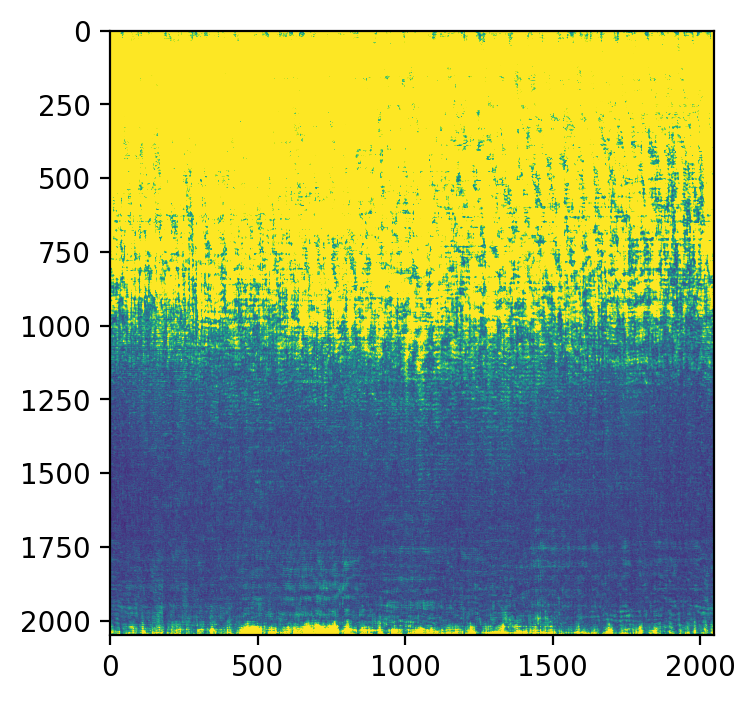

In [66]:
plt.figure(dpi=200)
plt.imshow(np.abs(PIE_probes[0]),vmax=1e-1)